# Rossby wave Model with 5 modes
## This jupyter notebook test inverse problem with swath samples

#### First we calculate the Brunt-Vaisla frequency squared with a sample dataset.

In [1]:
import numpy as np
import scipy
import gsw
import xarray as xr
import cmocean as cmo
from numpy import linalg as LA
from scipy import linalg

In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [3]:
state_ds = xr.open_dataset('../../Rossby_wave_test_case/MARA_RUN2_SWOT_state_2015-01-06.nc')
#state_ds #.PHIHYD #, state_ds.DRHODR

In [4]:
LAT, LON = state_ds.YC.data, state_ds.XC.data

In [5]:
lat, lon = np.meshgrid(LAT, LON)

# Read Temperature, Salinity and Pressure data

In [6]:
temp = state_ds.THETA
salinity = state_ds.SALT
Z = state_ds.Z
pres_anomalies  =  state_ds.PHIHYD

# Calculate Brunt-Vaisla frequency squared

In [7]:
SA, CT = np.ma.masked_all(salinity.shape), np.ma.masked_all(temp.shape)
Nsquared = np.ma.masked_all([salinity.shape[0]-1,salinity.shape[1], salinity.shape[2]])
Pressure_mid = np.ma.masked_all([salinity.shape[0]-1,salinity.shape[1], salinity.shape[2]])
pres = np.ma.masked_all([salinity.shape[0],salinity.shape[1], salinity.shape[2]])
Z_mid = np.ma.masked_all([salinity.shape[0]-1, salinity.shape[1], salinity.shape[2]])
for y in range(SA.shape[1]):
    for x in range(SA.shape[2]):
        pres[:, y, x] = gsw.p_from_z(Z.data,  lat = LAT[y]) #+ pres_anomalies.data[:, y, x]
        SA[:, y, x] = gsw.conversions.SA_from_SP(salinity.data[:, y, x], pres.data[:, y, x], LON[x], LAT[y])
        CT[:, y, x] = gsw.CT_from_pt(SA.data[:, y, x], temp.data[:, y, x])  
        Nsquared[:, y, x], Pressure_mid[:, y, x] = gsw.stability.Nsquared(SA[:, y, x], CT[:, y, x], pres[:, y, x])
        Z_mid[:, y, x] = gsw.z_from_p(Pressure_mid[:, y, x] , lat = LAT[y])

In [8]:
xlon, ylat = np.meshgrid(LON, LAT)

In [9]:
zz, yy = np.meshgrid(Z[1:], LAT)

### Choose a vector at a random location

In [10]:
laty, lonx = 130, 220

## Interpolate the N2 vector onto a uniform pressure grid

In [11]:
N2_vector = Nsquared[:, laty, lonx]
Pmid_vector = Pressure_mid[:, laty, lonx]
#Pmid_vector, N2_vector
for i in range(len(N2_vector)-1):
    if N2_vector[i] < 0:
        N2_vector[i] = N2_vector[i+1] #np.median(np.absolute(N2_vector))
    if N2_vector[i] == 0:
        N2_vector[i] = N2_vector[i+1] #np.median(np.absolute(N2_vector))

In [12]:
Pmid_uniform = np.arange(Pmid_vector[0], Pmid_vector[-1], step = 120)
N2_uniform = np.interp(Pmid_uniform, Pmid_vector[:-2], N2_vector[:-2])

In [13]:
Pmid_uniform = Pmid_uniform[:]
N2_uniform = N2_uniform[:]
#Pmid_uniform[:-16], N2_uniform[:-16]

In [14]:
import VERT_FSFB3

In [15]:
c2, Psi, G, N2, Pmid = VERT_FSFB3.VERT_FSFB3(N2_uniform[:-16], Pmid_uniform[:-16])

In [16]:
g = 9.81 # gravity

## With a rigid lid assumpsion, SSH = Gm/g, where g is gravity, since hydrastatic pressure p = $rho * g *  SSH$

In [17]:
SSH = G/g

In [18]:
Z_mid_uniform  = gsw.z_from_p(np.append(0,Pmid), lat = laty)

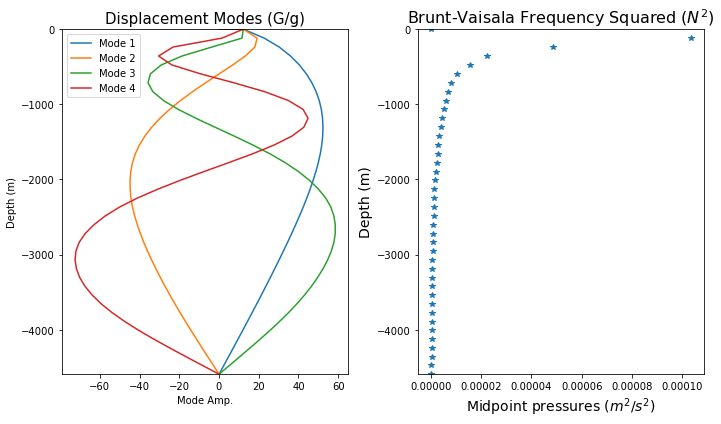

In [19]:
plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.plot(SSH[:,0], Z_mid_uniform, label = 'Mode 1')
plt.plot(SSH[:,1], Z_mid_uniform, label = 'Mode 2')
plt.plot(SSH[:,2], Z_mid_uniform, label = 'Mode 3')
plt.plot(SSH[:,3], Z_mid_uniform, label = 'Mode 4')
#plt.plot(SSH[:,4], Z_mid_uniform, label = 'Mode 5')
plt.xlabel('Mode Amp.')
plt.ylabel('Depth (m)')
#plt.xlim([-.2, .2])
plt.ylim([Z_mid_uniform.min(), 0])
plt.legend()
plt.title('Displacement Modes (G/g)', fontsize = 15)

plt.subplot(122)
plt.title('Brunt-Vaisala Frequency Squared ($N^2$)', fontsize = 16)
plt.plot(N2, Z_mid_uniform[1:], '*')
#plt.plot(Pmid_vector[:], N2_vector,  linewidth  = 2.0)
plt.xlabel('Midpoint pressures (${m^2}/{s^2}$)', fontsize = 14)
plt.ylabel('Depth (m)', fontsize = 14)
#plt.xlim([10, 350])
plt.ylim([Z_mid_uniform.min(), 0])

plt.tight_layout()
plt.savefig('vertical_modes_N2_sample_CCS_lon_' + str(lonx) + '_lat_' + str(laty) +'.png')

In [20]:
MODE = G.shape[-1]

In [21]:
Zgrid, mode = np.meshgrid(Z_mid_uniform, range(MODE) )

/var/folders/4w/wvmyk9216kl39tqqrtqcndl80000gn/T/ipykernel_41841/53837551.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(mode, Zgrid, SSH[:].T, cmap = cmo.cm.balance)
/var/folders/4w/wvmyk9216kl39tqqrtqcndl80000gn/T/ipykernel_41841/53837551.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(mode, Zgrid,G[:].T, cmap = cmo.cm.curl)
/var/folders/4w/wvmyk9216kl39tqqrtqcndl80000gn/T/ipykernel_41841/53837551.py:25: MatplotlibDeprec

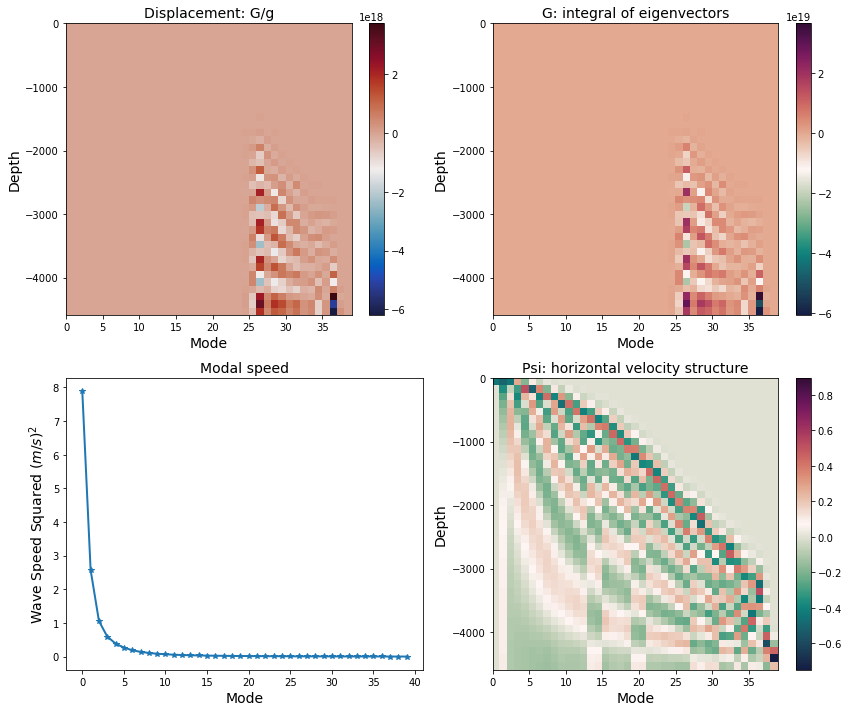

In [22]:
plt.figure(figsize = (12, 10))
plt.subplot(221)
plt.title('Displacement: G/g', fontsize = 14)
plt.pcolormesh(mode, Zgrid, SSH[:].T, cmap = cmo.cm.balance)
plt.ylabel('Depth', fontsize = 14)
plt.xlabel('Mode', fontsize = 14)
plt.colorbar()

plt.subplot(222)
plt.title('G: integral of eigenvectors', fontsize = 14)
plt.pcolor(mode, Zgrid,G[:].T, cmap = cmo.cm.curl)
plt.ylabel('Depth', fontsize = 14)
plt.xlabel('Mode', fontsize = 14)
plt.colorbar()

plt.subplot(223)
plt.title('Modal speed' , fontsize = 14)
plt.plot(c2[:], "-*", linewidth = 2)
plt.ylabel('Wave Speed Squared $(m/s)^2$', fontsize = 14)
plt.xlabel('Mode', fontsize = 14)
#plt.colorbar()

plt.subplot(224)
plt.title('Psi: horizontal velocity structure' , fontsize = 14)
plt.pcolor(mode, Zgrid, Psi[:].T, cmap = cmo.cm.curl)
plt.ylabel('Depth', fontsize = 14)
plt.xlabel('Mode', fontsize = 14)
plt.colorbar()

plt.tight_layout()
plt.savefig('vertical_modes_FSFB2_N2_sample_lon_' + str(lonx) + '_lat_' + str(laty) +'.png', dpi = 100)

### Beta plane paramters

In [23]:
Phi0 = 30 # central latitude (φ0)
Omega = 7.2921159e-5 # Ω is the angular speed of the earth
Earth_radius = 6.371e6 # meters
Beta = 2 * Omega * np.cos(Phi0) / Earth_radius
f0 = 2 * Omega * np.sin(Phi0) #1.0313e-4 # 45 N

### SSH - 15 waves, 5 baroclinic modes, 3 wavenumbers, 5 modes, 15 frequencies, 30 amplitudes

#### The dispersion relation relates frequency to wavenumber for each mode:

In [405]:
MModes = 5 # 
wavelength = np.array([2e5, 1e5, .5e5]) # 200km, 100km, 50km
wavespeed = c2[:MModes] # Phase speed
k_n = 2 * np.pi / wavelength # wavenumber
Rm = wavespeed[:MModes] / f0 # Rossby deformation radius
wavelength_l = 0.4 * wavelength
l_n = 2 * np.pi / wavelength_l # Y direction wavenumber
freq_n = np.zeros([len(wavelength), MModes])
for nn in range(len(k_n)):
    for mm in range(MModes):
        freq_n[nn, mm] = (Beta * k_n[nn]) / (k_n[nn] ** 2 + l_n[nn] ** 2 + Rm[mm] ** (-2))
Amp = np.random.rand(2, MModes, len(wavelength))
M = Amp.size

In [406]:
X_loc = np.arange(0, 1e6, 1e4) # domain size 1000 km with 10km resolution
Y_loc = np.arange(0, 1e6, 1e4)
T_time = np.arange(0, 1e10, 1e8) # Time step : ~11days

### H Matrix and SSH

In [407]:
%%time
H_cos = np.zeros([len(T_time), len(X_loc), len(Y_loc), MModes, len(wavelength)] ) # Number of waves * Number of data
H_sin = np.zeros([len(T_time), len(X_loc), len(Y_loc), MModes, len(wavelength)])
SSH_XYTMN = np.ma.masked_all([len(T_time), len(X_loc), len(Y_loc), MModes, len(wavelength)])
for tt in range(len(T_time)):
    for xx in range(len(X_loc)):
        for yy in range(len(Y_loc)):
            for mm in range(Amp.shape[1]):
                for nn in range(len(k_n)):
                    H_cos[tt, xx, yy, mm, nn] = Psi[0, mm] * np.cos(k_n[nn] * X_loc[xx] + l_n[nn] * Y_loc[yy] + freq_n[nn, mm] * T_time[tt]) 
                    H_sin[tt, xx, yy, mm, nn] = Psi[0, mm] * np.sin(k_n[nn] * X_loc[xx] + l_n[nn] * Y_loc[yy] + freq_n[nn, mm] * T_time[tt])

for mm in range(MModes):
    for nn in range(len(k_n)):
        SSH_XYTMN[:, :, :, mm, nn] = Amp[0, mm, nn] * H_cos[:, :, :, mm, nn] + Amp[1, mm, nn] * H_sin[:, :, :, mm, nn]

CPU times: user 1min 2s, sys: 311 ms, total: 1min 2s
Wall time: 1min 2s


#### Add up long the last two axis: modes, frequences

In [408]:
SSH_XYT = np.sum(SSH_XYTMN, axis = (-1, -2))

### Exact-solution - Solve 30 unknow amplitudes with 30 data points.

In [471]:

a, b, c, d = 0, 1, 50, 1

x0 = np.arange(0, 50, 1)
y0 = np.arange(0, 50, 1)
xswath_index0 = a + b * x0
yswath_index0 = c + d * y0
swath_ysize = 12
yswath_index = np.ma.masked_all([12, len(yswath_index0)])
xswath_index = np.ma.masked_all([12, len(xswath_index0)])
for yy in range(1, swath_ysize):
    if(yy!= 6&7):
        yswath_index[yy] = yswath_index0 + yy
        xswath_index[yy] = xswath_index0

#### SWOT swath: two 50km swaths with 20 km gap in middle

In [472]:
xswath_index.shape, y_mask.shape

((12, 50), (12, 50))

In [473]:
yswath_index = np.ma.masked_greater_equal(yswath_index, 100)
y_mask = np.ma.getmask(yswath_index)
xswath_index = np.ma.masked_where(((yswath_index ==100)&(yswath_index>100)), xswath_index) 
#xswath_index = np.ma.masked_array(xswath_index) #, mask = y_mask
xswath_index.compressed().size #np.ma.compressed(xswath_index)#.compressed()

440

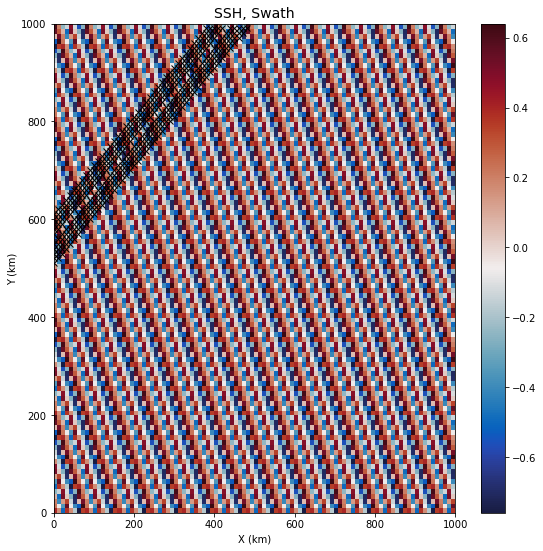

In [474]:
fig = plt.figure(figsize = (9, 9))
plt.pcolor(SSH_XYT[0], cmap = cmo.cm.balance)
plt.title('SSH, Swath', fontsize = 14)
for yy in range(swath_ysize):
    plt.plot(xswath_index0, yswath_index[yy] , 'x', color = 'black')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
plt.xticks(np.arange(0, 101, 20), np.arange(0, 1001, 200))
plt.yticks(np.arange(0, 101, 20), np.arange(0, 1001, 200)) #Resolution 10 km
plt.colorbar()
plt.savefig('swath_sample.png')

#### Retrieve valid data and random sample in time 

In [527]:
yvalid_index = yswath_index.compressed().astype(int) # retrieve the valid data 
xvalid_index = xswath_index.compressed().astype(int) # retrieve the valid data 
if(xvalid_index.size== yvalid_index.size):
    tindex = np.random.randint(low = 0, high= 99, size= xvalid_index.size)  # Random sampling in time

In [528]:
N = yvalid_index.size
N == xvalid_index.size

True

In [529]:
H_ = np.ma.masked_all([len(T_time), len(X_loc), len(Y_loc), MModes*2, len(wavelength)]) # Number of data * Number of models
H_[:, :, :, 0::2] = H_cos #.reshape([len(T_time), len(X_loc), len(Y_loc), 15], order='F')
H_[:, :, :, 1::2] = H_sin #.reshape([len(T_time), len(X_loc), len(Y_loc), 15], order='F')

In [530]:
# Convert the T, X, Y space to 1-dimensional space
IIndex = np.zeros(N) # N: Number of y data
Y_v = np.zeros(N) 
H_v = np.zeros([N, M]) # M: number of model
nx, ny = N, N
for iii in range(N):
    #print(tindex, xswath_index[iii], yswath_index[iii])
    IIndex[iii] = nx * ny * tindex[iii] + ny * xvalid_index[iii] + yvalid_index[iii]
    Y_v[iii] = SSH_XYT[tindex[iii], xvalid_index[iii], yvalid_index[iii]]
    for mm in range(MModes):
        for nn in range(len(wavelength)):
            H_IIndex = nx * ny * tindex[iii] + ny * xvalid_index[iii] + yvalid_index[iii] ## Data space
            JIndex = 2 * MModes * nn +  2 * mm  # Model space
            H_v[iii, JIndex] = H_cos[tindex[iii], xvalid_index[iii], yvalid_index[iii], mm, nn]
            H_v[iii, JIndex + 1] = H_sin[tindex[iii], xvalid_index[iii], yvalid_index[iii], mm, nn]

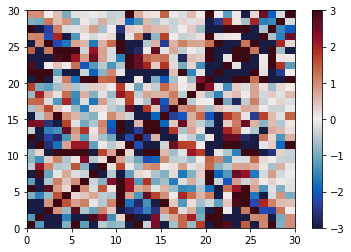

In [531]:
plt.pcolor(np.matmul(H_v.T, H_v), vmin = -3, vmax = 3, cmap = cmo.cm.balance)
plt.colorbar()

#### Weighted least square solution

In [532]:
num_samples = len(Y_loc)
noise_std = 2

In [533]:
SSH_WN = np.ma.masked_all(SSH_XYT.shape)
white_noise_x, white_noise_y = np.ma.masked_all(SSH_XYT.shape), np.ma.masked_all(SSH_XYT.shape)
for tt in range(len(T_time)):
    for yy in range(len(Y_loc)):
        white_noise_y[tt, yy] = np.random.normal(0, noise_std, size = num_samples)
        SSH_WN[tt, yy] = SSH_XYT[tt, yy]

#### R and P Matrix

In [534]:
R_ = np.eye(N, N)

In [535]:
P_ = np.eye(M, M)

In [536]:
for ii in range(N):
    R_[ii, ii] = .01 #(residual * 0.7) ** 2 # (half of the variance is noise) 1e-6  # Uncertainty in data

for ii in range(M):    
    P_[ii, ii] = 1 # Uncertainty in model

#### P matrix =0 For now

In [537]:
A = np.matmul(H_v.T, LA.inv(R_))

In [538]:
HRH = np.matmul(A, H_v)

In [539]:
D = np.matmul(np.matmul(LA.inv(HRH + LA.inv(P_)), H_v.T) , LA.inv(R_))

In [540]:
eig, vec = LA.eig(HRH)
eig.real

array([25615.85868336, 21696.51760275, 20075.98591292, 17843.14416724,
       17051.66515963, 15590.21785771,  6456.29464153,  6059.64929077,
        5788.16357506,  5271.43064214,  4779.86537289,  4304.7010559 ,
        4181.23410416,  4028.34308725,  3589.52157573,  3541.85607565,
          90.42636364,   103.97108823,  1901.14542245,  1801.85219028,
        1628.79297705,  1371.15361252,  1464.40041948,  1498.45412708,
         807.9991223 ,   739.32438557,   546.88493424,   681.86987676,
         588.78409183,   616.99423351])

#### Soution with noise

In [541]:
X_ = np.matmul(D, Y_v)

In [542]:
SOL_WN = X_ #.reshape([2, MModes, len(wavelength)], order = 'C')

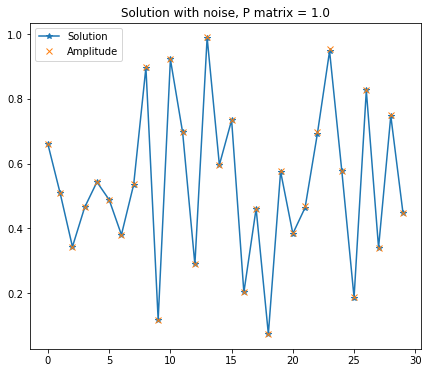

In [543]:
plt.figure(figsize = (7,6))
plt.plot(SOL_WN,'*-', label = 'Solution')
plt.plot(Amp.reshape([30], order = 'F'),'x',label = 'Amplitude')
plt.legend()
plt.title('Solution with noise, P matrix = ' + str(P_[0, 0]))
plt.savefig('inverse_problem_solution_N' + str(N)+'.png')

In [544]:
diff = SOL_WN - Amp.reshape([M], order = 'F')

In [545]:
rms = np.sqrt(np.mean(diff**2))
rms

0.00219120178993626

#### Check whether Y == Hx

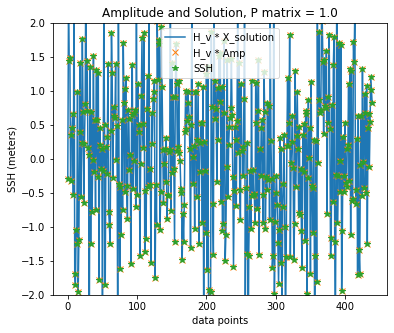

In [546]:
plt.figure(figsize = (6, 5))
plt.plot(np.matmul(H_v, SOL_WN), label = 'H_v * X_solution')
plt.plot(np.matmul(H_v, Amp.reshape([M], order = 'F')), 'x', label = 'H_v * Amp')
plt.plot(Y_v, '*', label = 'SSH')
plt.xlabel('data points')
plt.ylabel('SSH (meters)')
plt.legend(loc = 'best')
plt.ylim([-2, 2])
plt.title('Amplitude and Solution, P matrix = ' + str(P_[0, 0]) )
plt.savefig('SSH_Hv_X_solution_P'+ str(P_[0, 0])  +'.png')